<a href="https://colab.research.google.com/github/NaviDSX/2-S1/blob/main/DETR/Evaluating_DETR_on_COCO_validation_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to evaluate `DetrForObjectDetection` on the COCO evaluation 2017 dataset.

Make sure to set Runtime to GPU.

## Set up environment

We install Transformers straight from Github, and [timm](https://github.com/rwightman/pytorch-image-models/), which is the library that is used for the convolutional backbone of DETR. DETR uses a ResNet-50 (or ResNet-101 for its larger variant) as backbone.

In [1]:
!nvidia-smi

Mon Oct  4 17:41:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    90W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git timm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (namely `DetrFeatureExtractor`) to turn the data in COCO format in the format that DETR expects. It will resize the images and corresponding annotated bounding boxes, and normalize the images across the RGB channels using the ImageNet mean and standard deviation.

In [3]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension
        
        return pixel_values, target

When initializing the `test_dataset`, one should specify the path to the directory containing the images, and the directory containing the annotation JSON file. You can download COCO detection validation 2017 from the [official website](https://cocodataset.org/#download). I've stored them in my personal Google Drive. 

Note that we call it a test dataset here, wherehas COCO calls it a "validation" set. It consists of 5,000 annotated images.

In [4]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()

test_dataset = CocoDetection(img_folder='/content/drive/MyDrive/coco/val2017', 
                              ann_file='/content/drive/MyDrive/coco/instances_val2017.json',
                              feature_extractor=feature_extractor)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [5]:
#/content/drive/MyDrive/coco/val2017

In [6]:
print(len(test_dataset))

5000


Let's visualize a random image with its annotations:

Image n°128699


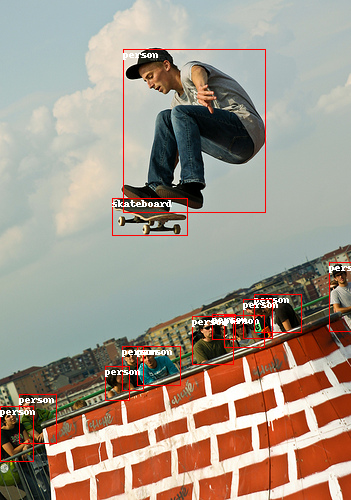

In [7]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = test_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/drive/MyDrive/coco/val2017', image['file_name']))

annotations = test_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Next, let's create a corresponding `test_dataloader`. As `DetrFeatureExtractor` resizes every image with a min_size of 800 and a max_size of 1333, images can have different sizes. Hence, we define a custom `collate_fn`, which will batch images and corresponding labels together, by padding images in a batch up to the largest one, and also create a `pixel_mask` that indicates which pixels are real/which are padding. 

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1)

Let's verify the first batch:

In [9]:
batch = next(iter(test_dataloader))
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [10]:
batch['pixel_values'].shape

torch.Size([1, 3, 800, 1201])

In [11]:
batch['pixel_mask'].shape

torch.Size([1, 800, 1201])

## Run evaluation

Finally, we can run the evaluation. The original implementation of DETR (by Facebook AI) contains a nice `CocoEvaluator` object, which allows us to easily compute the metrics. Let's use it, by git cloning the original repository.

In [12]:
! git clone https://github.com/facebookresearch/detr.git
%cd detr

fatal: destination path 'detr' already exists and is not an empty directory.
/content/detr


We initialize the `CocoEvaluator` by providing the ground truths to it.

In [19]:
from datasets import get_coco_api_from_dataset
from datasets.coco_eval import CocoEvaluator

base_ds = get_coco_api_from_dataset(test_dataset) # this is actually just calling the coco attribute
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

Now, let's load the trained model from HuggingFace's model hub, and run the evaluation, batch by batch. Each time a batch is processed, the metrics are added to the `CocoEvaluator`.

In [20]:
from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Below, we move the model to the GPU. Note that we don't need to put the model in evaluation mode (`model.eval()`) as this is done by default by the .`from_pretrained()` method above. We use the `tqdm` library to print a nice progress bar.

As this can take a while, I limitted the evaluation below to 50 batches. You can of course remove that statement to run the evaluation on the entire validation set.

In [21]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import torch
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print("Running evaluation...")

# let's limit the number of batches for now
nbatches = 250
li=[]
for idx, batch in enumerate(tqdm(test_dataloader)):
    
    if idx > nbatches:
        break
    
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    navi = (pixel_values,pixel_mask,labels,outputs,orig_target_sizes,results,res)
    li.append(navi)
    coco_evaluator.update(res)

Running evaluation...


  0%|          | 0/5000 [00:00<?, ?it/s]

In [42]:
type(res), len(res)

(dict, 1)

In [45]:
res.keys()

dict_keys([25593])

In [46]:
res

{25593: {'boxes': tensor([[ 1.9419e+02,  2.7303e+02,  5.0282e+02,  4.4149e+02],
          [ 2.5251e+02,  3.4737e+01,  3.2689e+02,  1.3136e+02],
          [ 2.3629e+02,  3.2860e+02,  5.0242e+02,  4.5083e+02],
          [ 2.8322e+02,  4.7464e+01,  3.1812e+02,  1.1695e+02],
          [ 2.5465e+02,  3.3034e+01,  3.1544e+02,  1.1212e+02],
          [ 2.5947e+02,  7.8462e+01,  4.0300e+02,  1.9733e+02],
          [ 2.7581e+02,  1.2392e+02,  3.4223e+02,  1.6832e+02],
          [ 2.6490e+02,  1.0769e+02,  3.9604e+02,  1.8852e+02],
          [ 2.5443e+02,  4.0931e+01,  2.8250e+02,  1.0265e+02],
          [ 2.5533e+02,  3.3809e+01,  3.1692e+02,  1.1240e+02],
          [ 2.3249e+02,  3.0069e+02,  5.0238e+02,  4.4843e+02],
          [ 2.3328e+02,  3.3331e+02,  5.0776e+02,  4.5344e+02],
          [ 2.2176e+02,  1.9201e+02,  4.9865e+02,  4.4311e+02],
          [ 2.9183e+02,  3.4831e+02,  4.9918e+02,  4.3373e+02],
          [ 2.3012e+02,  3.7486e+02,  3.6869e+02,  4.5927e+02],
          [ 1.7654e+02, 

In [47]:
res.to("cpu")

AttributeError: ignored

In [50]:
#if you are using pickle load on a cpu device, from a gpu device
#you will need to override the pickle load functionality like this:
#note: if loading directly in torch, just add map_location='cpu' in load()
import pickle
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

#contents = pickle.load(f) becomes...
#contents = CPU_Unpickler(f).load()

Finally, we can accumulate the metrics, and print a summary. This is what I got printed:


```
Accumulating evaluation results...
DONE (t=0.44s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.845
 ```



In [16]:
coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.768
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.675
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [17]:
hello+5

NameError: ignored

In [22]:
len(li)

251

In [ ]:
li[0]

In [ ]:
!pip install pyperclip

In [ ]:
import pyperclip as pc

In [ ]:
pc.copy(li)

In [ ]:
with open('li.txt', 'wb') as f:
   pickle.dump(li, f)

In [ ]:
import pickle

In [ ]:
!pwd

In [ ]:
li

In [23]:
def ana(a):
    if type(a) == list:
        print(f' Type is list and Length is {len(a)} First 10 elements ana is \n ')
        for i in range[10]:
            print('f {type(a)}, {len(a)}')
    if type(a) == dict:
        print('f Type is dict and Length is {len(a)}')
        print(a.keys())
        for i in a.values():
            print(f'{type(i)}    {len(i)}    {i.shape if hasattr(i,"shape") else ""}')
    else: print (f' Datatype is {type(a)}')

In [25]:
len(li), type(li)

(251, list)

In [27]:
li0=li[0]

In [28]:
len(li0), type(li0)

(7, tuple)

In [32]:
type(li0[5])

list

In [33]:
li05=li0[5]

In [35]:
type(li05[0])

dict

In [36]:
li050=li05[0]

In [37]:
li050.keys()

dict_keys(['scores', 'labels', 'boxes'])

In [38]:
li050

{'boxes': tensor([[ 44.7362, 218.7156,  56.4713, 241.1089],
         [349.7916, 207.5652, 359.0851, 225.3820],
         [170.1655, 256.8620, 191.8607, 273.7443],
         [386.6974, 192.1540, 406.0742, 213.9995],
         [332.3640, 183.9873, 350.2176, 218.4853],
         [324.2139, 212.9055, 378.5836, 303.4502],
         [345.3749, 213.8162, 354.8742, 228.7774],
         [243.5903, 198.5119, 252.7092, 212.3913],
         [246.1276, 194.3569, 257.7987, 211.9706],
         [248.2481, 198.6134, 257.9734, 212.6662],
         [411.4124, 219.8475, 442.4585, 304.9903],
         [166.1319, 233.6600, 184.0982, 266.7091],
         [451.6516, 172.2215, 514.3516, 289.6111],
         [549.8943, 292.2537, 577.0322, 340.5878],
         [347.7859, 215.6610, 356.8514, 231.0428],
         [  0.6750, 166.8445, 154.4370, 268.2761],
         [ 51.9190, 216.6681,  62.6365, 240.4670],
         [459.0577, 159.7356, 470.3534, 168.1294],
         [462.2328, 218.9286, 493.5730, 292.2066],
         [341.0997, 20

In [40]:
li.to(cpu)

AttributeError: ignored